In [1]:
# IMPORTS

from GridClass import *

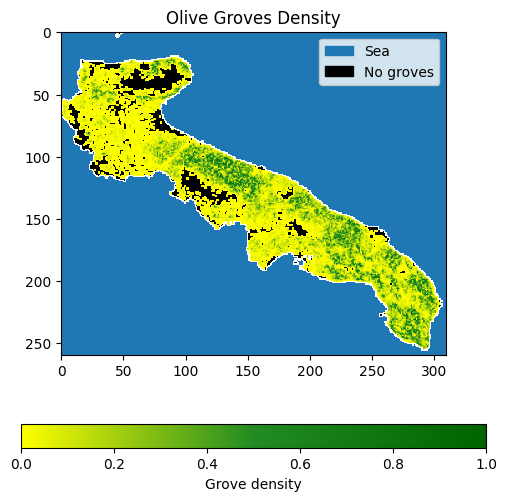

In [2]:
# CREATE OLIVE GROVE DENSITY, FROM FILE OR RANDOMLY GENERATED

np.random.seed(5)

FROM_FILE = True

if FROM_FILE:
    file_path = "olivegrowthprop.mat"
    mat = sp.io.loadmat(file_path)
    GRID = Grid(density=mat["olivegrowthprop"])

else:
    H = 4
    W = 4
    GRID = Grid(shape=(H,W))

# PLOT DISTRIBUTION OF OLIVE GROVES
GRID.plot_density(figsize=(6,6))

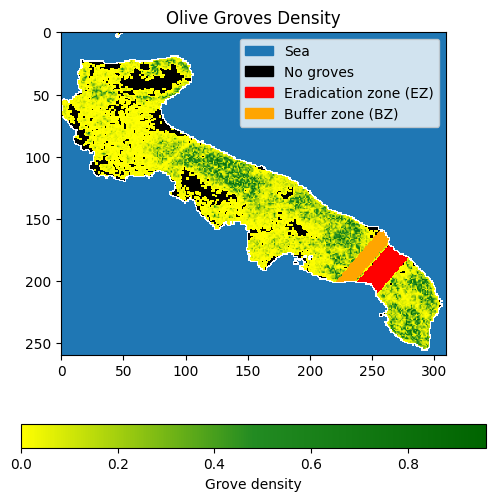

In [3]:
# SET CONTROL ZONE

if FROM_FILE:
    GRID.set_control_zone(EZW=20, BZW=13)
    GRID.plot_density(figsize=(6,6))

In [ ]:
# SHORT DISTANCE KERNEL

beta = 0.1
GRID.set_short_distance_kernel(beta)
GRID.plot_short_distance_kernel(figsize=(6,6))

In [ ]:
# SET MODEL PARAMETERS

np.random.seed(13340)

# Common parameters
A = 3 # 3 kp rate of population growth
B = 14.069
a = 0 # relative carrying capacity in non olive plants
tol = 1e-8 # 1e-8 numerical noise tolerance (IF TOLERANCE IS TOO BIG, IT CAN HAPPEN THAT THE SIMULATION IS TRUNCATED AT THE FIRST ITERATION)

# Short distance kernel
beta = 0.1

# Long distance kernel
disp_tol = 0.2 # 0.2 strattol stratified dispersal tolerance (threshold probability)
M_max = 5 # 5 maximum number of dispersers
D = 20 # 20 dispersal standard deviation

# Levy flight
n_vectors = 100
d_min = 0.1
alpha = 2
sample = "power"

# Define parameter dictionary
parameters = {'common': [A, B, a, tol],
              'short_long': [beta, disp_tol, M_max, D],
              'levy_flight': [n_vectors, d_min, alpha, sample]}

In [ ]:
# RUN SIMULATION AND PLOT OUTCOME

timesteps = 5
dispersal_type = "short_long"

GRID.simulate(timesteps, parameters, dispersal_type=dispersal_type)
GRID.plot_incidence(figsize=(6,6))

In [ ]:
# Evaluate risk for N simulations of 5 years

N = 10
final_incidence = np.zeros((N, GRID.rows, GRID.cols))

for i in range(N):
    GRID.simulate(timesteps, parameters, dispersal_type=dispersal_type)
    final_incidence[i] = GRID.output[GRID.timesteps]
    GRID.plot_final_incidence(figsize=(6,6))

In [ ]:
risk = np.mean(final_incidence, axis=0)
im_sea = np.ma.array(GRID.density, mask=~GRID.sea_mask)

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(risk, cmap="inferno", interpolation=None, norm=colors.Normalize(vmin=0, vmax=1))
ax.imshow(im_sea, cmap=colors.ListedColormap(['tab:blue']), interpolation=None)
ax.set_title("5-year risk")
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label("Risk")

plt.show()